## 1A - Imports

In [65]:
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
from more_itertools import locate

# SK-Learn
from skimage.feature import hog
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

filepath = 'data/'

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

rawdata = unpickle(filepath + "data_batch_1")
labelNames = [name.decode() for name in unpickle(filepath + "batches.meta")[b'label_names']]
rawtestdata = unpickle(filepath + "test_batch")

print(labelNames)
print(rawdata[b'data'].shape)
print(rawtestdata[b'data'].shape)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(10000, 3072)
(10000, 3072)


#### Convert raw batch data to numpy array of images

airplane


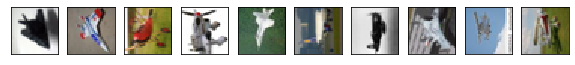

automobile


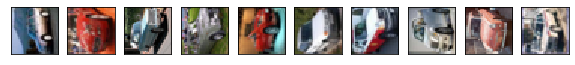

bird


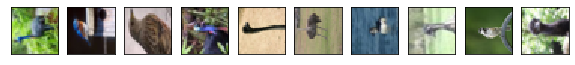

cat


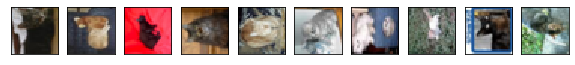

deer


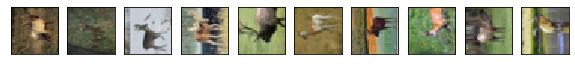

dog


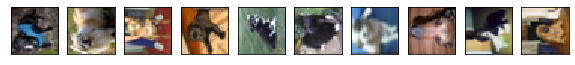

frog


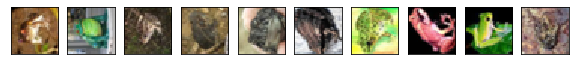

horse


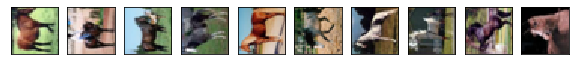

ship


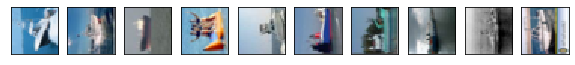

truck


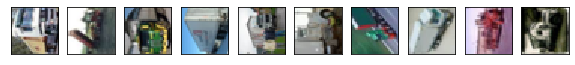

In [84]:
imageData = rawdata[b'data'].reshape((10000, 32, 32, 3), order='F')
imageLabels = np.asarray(rawdata[b'labels'])
testImageData = rawtestdata[b'data'].reshape((10000, 32, 32, 3), order='F')
testImageLabels = np.asarray(rawtestdata[b'labels'])

# display the first 10 images with each label
for label in range(10):
    firstLabels = list(locate(imageLabels, lambda l: l == label))[:10]
    print(labelNames[label])
    plt.figure(figsize=(10, 2))
    for i, index in enumerate(firstLabels):
        plt.subplot(1, 10, i + 1), plt.imshow(imageData[index]), plt.xticks([]), plt.yticks([])
    plt.show()

## 1B - Feature Extraction
### Mean Intensity Values

In [47]:
meanIntensityValues = np.empty((10000, 3))    # in order: R, G, B
testMeanIntensityValues = np.empty((10000, 3))

for index, (image, testImage) in enumerate(zip(imageData, testImageData)):
    for layer in range(3):
        meanIntensityValues[index][layer] = np.mean(image[:][:][layer])
        testMeanIntensityValues[index][layer] = np.mean(testImageData[:][:][layer])
print(meanIntensityValues.shape)
print(testMeanIntensityValues.shape)

(10000, 3)
(10000, 3)


### HoG

In [48]:
hogFeatures = np.asarray([hog(image, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)) for image in imageData])
testHogFeatures = np.asarray([hog(testImage, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)) for testImage in testImageData])
print(hogFeatures.shape)
print(testHogFeatures.shape)

(10000, 324)
(10000, 324)


### Train-Test Split

In [49]:
X_trn_mean = meanIntensityValues
X_trn_hog = hogFeatures
Y_trn = imageLabels
X_test_mean = testMeanIntensityValues
X_test_hog = testHogFeatures
Y_test = testImageLabels

## 2 - SVM Classifiers
### Linear SVMs - Exploring Features

Mean Intensity Accuracy: 0.1
HoG Accuracy: 0.5102


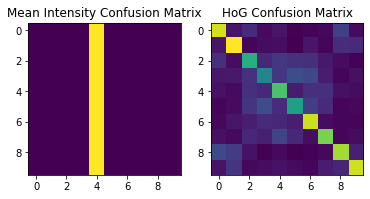

In [88]:
# create SVM models
svm_means = svm.SVC(kernel='linear', gamma='scale')
svm_hog = svm.SVC(kernel='linear', gamma='scale')

# train SVM models
svm_means.fit(X_trn_mean, Y_trn)
svm_hog.fit(X_trn_hog, Y_trn)

# evaluate SVM models with the confusion matrix and with accuracy
mean_predictions = svm_means.predict(X_test_mean)
hog_predictions = svm_hog.predict(X_test_hog)
print('Mean Intensity Accuracy: {}'.format(accuracy_score(Y_test, mean_predictions)))
print('HoG Accuracy: {}'.format(accuracy_score(Y_test, hog_predictions))) 
plt.subplot(121), plt.imshow(confusion_matrix(Y_test, mean_predictions)), plt.title('Mean Intensity Confusion Matrix')
plt.subplot(122), plt.imshow(confusion_matrix(Y_test, hog_predictions)), plt.title('HoG Confusion Matrix')
plt.show()

### Non-Linear SVMs - Exploring SVM Kernels

Polynomial Accuracy: 0.5628
Radial Basis Function Accuracy: 0.5758


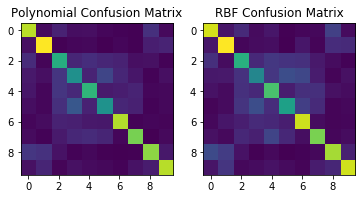

In [87]:
# create SVM models
svm_poly = svm.SVC(kernel='poly', gamma='scale')
svm_rbf = svm.SVC(kernel='rbf', gamma='scale')

# train SVM models
svm_poly.fit(X_trn_hog, Y_trn)
svm_rbf.fit(X_trn_hog, Y_trn)

# evaluate SVM models with the confusion matrix and with accuracy
poly_predictions = svm_poly.predict(X_test_hog)
rbf_predictions = svm_rbf.predict(X_test_hog)
print('Polynomial Accuracy: {}'.format(accuracy_score(Y_test, poly_predictions)))
print('Radial Basis Function Accuracy: {}'.format(accuracy_score(Y_test, rbf_predictions)))
plt.subplot(121), plt.imshow(confusion_matrix(Y_test, poly_predictions)), plt.title('Polynomial Confusion Matrix')
plt.subplot(122), plt.imshow(confusion_matrix(Y_test, hog_predictions)), plt.title('RBF Confusion Matrix')
plt.show()

The accuracy of polynomial SVM is about 5% higher than the accuracy of linear SVM. The accuracy of RBF SVM is about 7.5% higher than the accuracy of linear SVM. 

TODO: Is this result expected?

## 3 - Random Forest Classifiers
### RF - Exploring Performance of HoG Features

Random Forest Accuracy: 0.4761


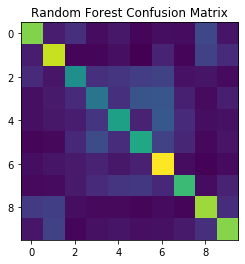

In [89]:
# create random forest classifier
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')

# train classifier
rf.fit(X_trn_hog, Y_trn)

# evaluate classifier performance
rf_predictions = rf.predict(X_test_hog)
print('Random Forest Accuracy: {}'.format(accuracy_score(Y_test, rf_predictions)))
plt.imshow(confusion_matrix(Y_test, rf_predictions)), plt.title('Random Forest Confusion Matrix')
plt.show()

### RF - Exploring Different Number of Trees (estimators)

Random Forest 40-tree Accuracy: 0.4317
Random Forest 200-tree Accuracy: 0.4964
Random Forest 250-tree Accuracy: 0.4984


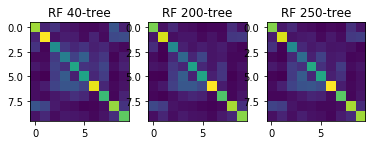

In [53]:
# create random forest classifier
rf40 = RandomForestClassifier(n_estimators=40, criterion='entropy')
rf200 = RandomForestClassifier(n_estimators=200, criterion='entropy')
rf250 = RandomForestClassifier(n_estimators=250, criterion='entropy')

# train classifier
rf40.fit(X_trn_hog, Y_trn)
rf200.fit(X_trn_hog, Y_trn)
rf250.fit(X_trn_hog, Y_trn)

# evaluate classifier performance
rf40_predictions = rf40.predict(X_test_hog)
rf200_predictions = rf200.predict(X_test_hog)
rf250_predictions = rf250.predict(X_test_hog)
print('Random Forest 40-tree Accuracy: {}'.format(accuracy_score(Y_test, rf40_predictions)))
print('Random Forest 200-tree Accuracy: {}'.format(accuracy_score(Y_test, rf200_predictions)))
print('Random Forest 250-tree Accuracy: {}'.format(accuracy_score(Y_test, rf250_predictions)))
plt.subplot(131), plt.imshow(confusion_matrix(rf40_predictions, Y_test)), plt.title('RF 40-tree')
plt.subplot(132), plt.imshow(confusion_matrix(rf200_predictions, Y_test)), plt.title('RF 200-tree')
plt.subplot(133), plt.imshow(confusion_matrix(rf250_predictions, Y_test)), plt.title('RF 250-tree')
plt.show()

The accuracy of the random forest classifier improves as the number of trees is increased. Out of the estimators tested, performance is best when 250 trees are used. Increasing the number of trees has diminishing marginal returns, because accuracy only increases by a very small amount between 200 and 250 trees. This indicates that the classifier is beginning to overfit to the training set, and accuracy would likely start to decrease if the number of trees were to be increased enough.

## 4 - Comparison of Classifiers
### Performance Analysis

SVM RBF Training Set Accuracy: 0.8233
Random Forest 250-tree Training Set Accuracy: 1.0


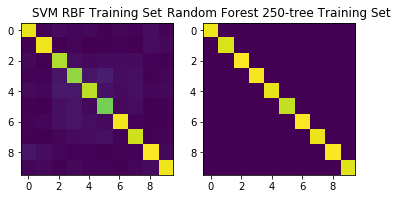

Radial Basis Function Accuracy: 0.5758
Random Forest 200-tree Accuracy: 0.4984


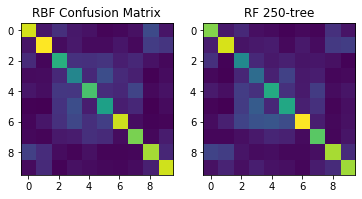

In [56]:
# predictions on training set for both classifiers
svm_rbf_trn_predictions = svm_rbf.predict(X_trn_hog)
rf250_trn_predictions = rf250.predict(X_trn_hog)
print('SVM RBF Training Set Accuracy: {}'.format(accuracy_score(Y_trn, svm_rbf_trn_predictions)))
print('Random Forest 250-tree Training Set Accuracy: {}'.format(accuracy_score(Y_trn, rf250_trn_predictions)))
plt.subplot(121), plt.imshow(confusion_matrix(svm_rbf_trn_predictions, Y_trn)), plt.title('SVM RBF Training Set')
plt.subplot(122), plt.imshow(confusion_matrix(rf250_trn_predictions, Y_trn)), plt.title('Random Forest 250-tree Training Set')
plt.show()

# re-print test set results for convenience
print('Radial Basis Function Accuracy: {}'.format(accuracy_score(Y_test, rbf_predictions)))
print('Random Forest 250-tree Accuracy: {}'.format(accuracy_score(Y_test, rf250_predictions)))
plt.subplot(121), plt.imshow(confusion_matrix(hog_predictions, Y_test)), plt.title('RBF Confusion Matrix')
plt.subplot(122), plt.imshow(confusion_matrix(rf250_predictions, Y_test)), plt.title('RF 250-tree')
plt.show()

On the training set, the SVM-RBF and 250-tree Random Forest classifiers both perform well (as they should, since they are being tested on the same data they trained on). The Random Forest classifier scores 100% accuracy on the task, but the SVM-RBF classifier's 82.3% performance might indicate that this classifier is not able to overfit the training set becuase its structure is not well-suited to this task. However, that indication is overturned on the test set, where the SVM-RBF classifier outperforms the  Random Forest classifier by about 8%. This result on the test set indicates that the Random Forest classifier is likely overfitting to the training set, resulting in poor performance on the test set.

TODO compare confusion matrices

TODO Is there any particular class which is hard to classify for SVM but easier for RF or vice versa?

### Exploring Different Parameters of HoG

SVM-RBF Accuracy with cellsize=6, blocksize=1, orientationbins=8: 0.504
RF 250-tree Accuracy with cellsize=6, blocksize=1, orientationbins=8: 0.4288


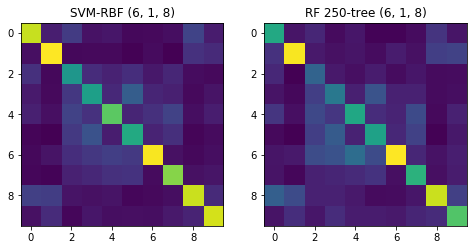

SVM-RBF Accuracy with cellsize=6, blocksize=1, orientationbins=10: 0.5099
RF 250-tree Accuracy with cellsize=6, blocksize=1, orientationbins=10: 0.431


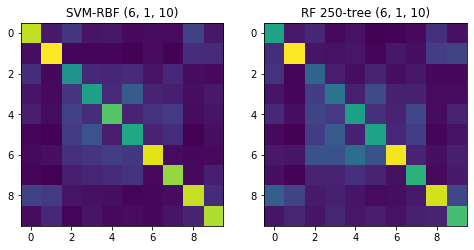

SVM-RBF Accuracy with cellsize=6, blocksize=3, orientationbins=8: 0.5918
RF 250-tree Accuracy with cellsize=6, blocksize=3, orientationbins=8: 0.495


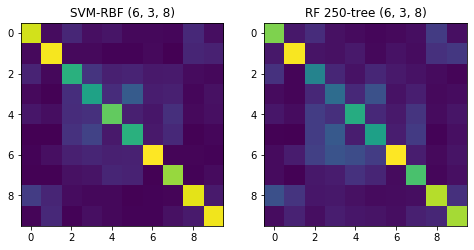

SVM-RBF Accuracy with cellsize=6, blocksize=3, orientationbins=10: 0.5877
RF 250-tree Accuracy with cellsize=6, blocksize=3, orientationbins=10: 0.4839


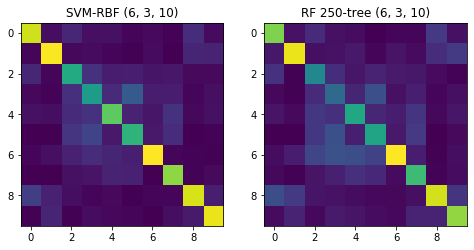

SVM-RBF Accuracy with cellsize=10, blocksize=1, orientationbins=8: 0.4607
RF 250-tree Accuracy with cellsize=10, blocksize=1, orientationbins=8: 0.4203


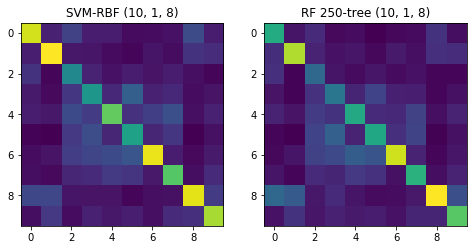

SVM-RBF Accuracy with cellsize=10, blocksize=1, orientationbins=10: 0.474
RF 250-tree Accuracy with cellsize=10, blocksize=1, orientationbins=10: 0.4311


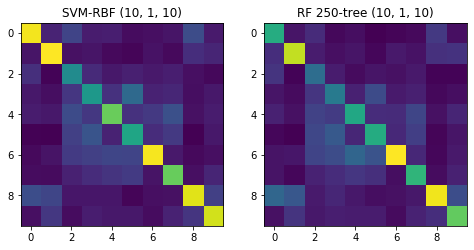

SVM-RBF Accuracy with cellsize=10, blocksize=3, orientationbins=8: 0.5632
RF 250-tree Accuracy with cellsize=10, blocksize=3, orientationbins=8: 0.4989


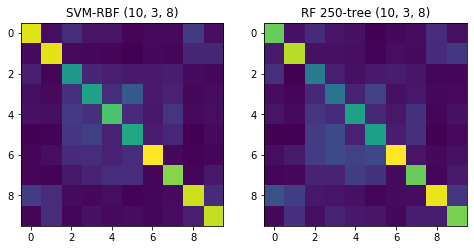

SVM-RBF Accuracy with cellsize=10, blocksize=3, orientationbins=10: 0.5636
RF 250-tree Accuracy with cellsize=10, blocksize=3, orientationbins=10: 0.4982


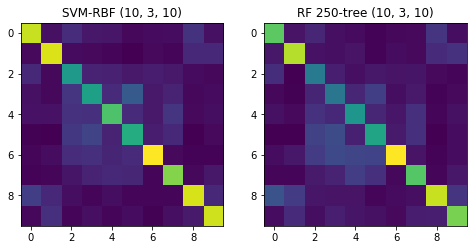

In [59]:
svm_rbf_hogtest = svm.SVC(kernel='rbf', gamma='scale')
rf250_hogtest = RandomForestClassifier(n_estimators=250, criterion='entropy')
variedHoGpredictions = np.empty((8, 2, 10000))   # saved in order of for loop

index = 0
for cellsize in [6, 10]:
    for blocksize in [1, 3]:
        for orientationbins in [8, 10]:
            hogIterFeatures = np.asarray([hog(image, orientations=orientationbins, pixels_per_cell=(cellsize,cellsize), cells_per_block=(blocksize,blocksize)) for image in imageData])
            testHogIterFeatures = np.asarray([hog(testImage, orientations=orientationbins, pixels_per_cell=(cellsize,cellsize), cells_per_block=(blocksize,blocksize)) for testImage in testImageData])
            
            svm_rbf_hogtest.fit(hogIterFeatures, Y_trn)
            rf250_hogtest.fit(hogIterFeatures, Y_trn)
            
            svm_rbf_hogtest_predictions = svm_rbf_hogtest.predict(testHogIterFeatures)
            rf250_hogtest_predictions = rf250_hogtest.predict(testHogIterFeatures)
            variedHoGpredictions[index][0] = svm_rbf_hogtest_predictions
            variedHoGpredictions[index][1] = rf250_hogtest_predictions
            print('SVM-RBF Accuracy with cellsize={}, blocksize={}, orientationbins={}: {}'.format(cellsize, blocksize, orientationbins, accuracy_score(Y_test, svm_rbf_hogtest_predictions)))
            print('RF 250-tree Accuracy with cellsize={}, blocksize={}, orientationbins={}: {}'.format(cellsize, blocksize, orientationbins, accuracy_score(Y_test, rf250_hogtest_predictions)))
            plt.figure(figsize=(8, 4))
            plt.subplot(121), plt.imshow(confusion_matrix(svm_rbf_hogtest_predictions, Y_test)), plt.title('SVM-RBF ({}, {}, {})'.format(cellsize, blocksize, orientationbins))
            plt.subplot(122), plt.imshow(confusion_matrix(rf250_hogtest_predictions, Y_test)), plt.title('RF 250-tree ({}, {}, {})'.format(cellsize, blocksize, orientationbins))
            plt.show()

In [ ]:
# TODO combine results into a plot for visual overlook of performance
# SVM-RBF Accuracy with cellsize=6, blocksize=3, orientationbins=8: 0.5918
# RF 250-tree Accuracy with cellsize=10, blocksize=3, orientationbins=8: 0.4989

TODO: report best-performing results from test above

### Folded Validation

SVM RBF Batch 2 Accuracy: 0.5867
SVM RBF Batch 3 Accuracy: 0.5839
SVM RBF Batch 4 Accuracy: 0.5905
RF250 Batch 2 Accuracy: 0.5033
RF250 Batch 3 Accuracy: 0.4946
RF250 Batch 4 Accuracy: 0.4976


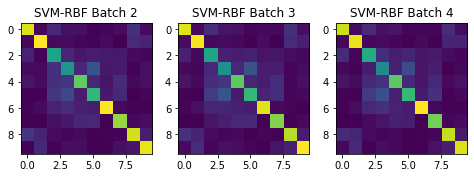

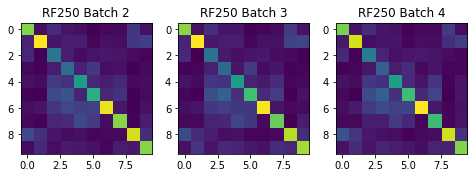

In [61]:
# best hyperparameters from above testing (TODO might be different for SVM and RF)
svmcellsize = (6, 6)
rfcellsize = (10, 10)
bestblocksize = (3, 3)
bestorientationbins = 8

# import block 2, 3, 4 data, extracting features using the best HoG paramaters discovered above
rawdata2 = unpickle(filepath + "data_batch_2")
rawdata3 = unpickle(filepath + "data_batch_3")
rawdata4 = unpickle(filepath + "data_batch_4")
imageData2 = rawdata2[b'data'].reshape((10000, 32, 32, 3), order='F')
imageData3 = rawdata3[b'data'].reshape((10000, 32, 32, 3), order='F')
imageData4 = rawdata4[b'data'].reshape((10000, 32, 32, 3), order='F')
imageLabels2 = np.asarray(rawdata2[b'labels'])
imageLabels3 = np.asarray(rawdata3[b'labels'])
imageLabels4 = np.asarray(rawdata4[b'labels'])
svmHoGFeatures2 = np.asarray([hog(image, orientations=bestorientationbins, pixels_per_cell=svmcellsize, cells_per_block=bestblocksize) for image in imageData2])
svmHoGFeatures3 = np.asarray([hog(image, orientations=bestorientationbins, pixels_per_cell=svmcellsize, cells_per_block=bestblocksize) for image in imageData3])
svmHoGFeatures4 = np.asarray([hog(image, orientations=bestorientationbins, pixels_per_cell=svmcellsize, cells_per_block=bestblocksize) for image in imageData4])
testSVMfeatures = np.asarray([hog(testImage, orientations=bestorientationbins, pixels_per_cell=svmcellsize, cells_per_block=bestblocksize) for testImage in testImageData])
rfHoGFeatures2 = np.asarray([hog(image, orientations=bestorientationbins, pixels_per_cell=rfcellsize, cells_per_block=bestblocksize) for image in imageData2])
rfHoGFeatures3 = np.asarray([hog(image, orientations=bestorientationbins, pixels_per_cell=rfcellsize, cells_per_block=bestblocksize) for image in imageData3])
rfHoGFeatures4 = np.asarray([hog(image, orientations=bestorientationbins, pixels_per_cell=rfcellsize, cells_per_block=bestblocksize) for image in imageData4])
testRFfeatures = np.asarray([hog(testImage, orientations=bestorientationbins, pixels_per_cell=rfcellsize, cells_per_block=bestblocksize) for testImage in testImageData])

# create and train 6 classifiers on that data (3 RF-250tree, 3 SVM-RBF)
svm_rbf_batch2 = svm.SVC(kernel='rbf', gamma='scale').fit(svmHoGFeatures2, imageLabels2)
svm_rbf_batch3 = svm.SVC(kernel='rbf', gamma='scale').fit(svmHoGFeatures3, imageLabels3)
svm_rbf_batch4 = svm.SVC(kernel='rbf', gamma='scale').fit(svmHoGFeatures4, imageLabels4)
rf250_batch2 = RandomForestClassifier(n_estimators=250, criterion='entropy').fit(rfHoGFeatures2, imageLabels2)
rf250_batch3 = RandomForestClassifier(n_estimators=250, criterion='entropy').fit(rfHoGFeatures3, imageLabels3)
rf250_batch4 = RandomForestClassifier(n_estimators=250, criterion='entropy').fit(rfHoGFeatures4, imageLabels4)

# test the classifiers using the test set and report accuracies on each batch
svm_rbf_batch2_predictions = svm_rbf_batch2.predict(testSVMfeatures)
svm_rbf_batch3_predictions = svm_rbf_batch3.predict(testSVMfeatures)
svm_rbf_batch4_predictions = svm_rbf_batch4.predict(testSVMfeatures)
rf250_batch2_predictions = rf250_batch2.predict(testRFfeatures)
rf250_batch3_predictions = rf250_batch3.predict(testRFfeatures)
rf250_batch4_predictions = rf250_batch4.predict(testRFfeatures)
print('SVM RBF Batch 2 Accuracy: {}'.format(accuracy_score(Y_test, svm_rbf_batch2_predictions)))
print('SVM RBF Batch 3 Accuracy: {}'.format(accuracy_score(Y_test, svm_rbf_batch3_predictions)))
print('SVM RBF Batch 4 Accuracy: {}'.format(accuracy_score(Y_test, svm_rbf_batch4_predictions)))
print('RF250 Batch 2 Accuracy: {}'.format(accuracy_score(Y_test, rf250_batch2_predictions)))
print('RF250 Batch 3 Accuracy: {}'.format(accuracy_score(Y_test, rf250_batch3_predictions)))
print('RF250 Batch 4 Accuracy: {}'.format(accuracy_score(Y_test, rf250_batch4_predictions)))

plt.figure(figsize=(8, 4))
plt.subplot(131), plt.imshow(confusion_matrix(svm_rbf_batch2_predictions, Y_test)), plt.title('SVM-RBF Batch 2')
plt.subplot(132), plt.imshow(confusion_matrix(svm_rbf_batch3_predictions, Y_test)), plt.title('SVM-RBF Batch 3')
plt.subplot(133), plt.imshow(confusion_matrix(svm_rbf_batch4_predictions, Y_test)), plt.title('SVM-RBF Batch 4')
plt.show()
plt.figure(figsize=(8, 4))
plt.subplot(131), plt.imshow(confusion_matrix(rf250_batch2_predictions, Y_test)), plt.title('RF250 Batch 2')
plt.subplot(132), plt.imshow(confusion_matrix(rf250_batch3_predictions, Y_test)), plt.title('RF250 Batch 3')
plt.subplot(133), plt.imshow(confusion_matrix(rf250_batch4_predictions, Y_test)), plt.title('RF250 Batch 4')
plt.show()

TODO: Do you see higher accuracy for any particular fold (1 through 4)? If yes, what might be the reason

### Ensemble Classifier

In [63]:
classifiers = [('svmb2', svm_rbf_batch2), ('svmb3', svm_rbf_batch3), ('svmb4', svm_rbf_batch4),
               ('rfb2', rf250_batch2), ('rfb3', rf250_batch3), ('rfb4', rf250_batch4)]
accweights = [accuracy_score(Y_test, svm_rbf_batch2_predictions),
          accuracy_score(Y_test, svm_rbf_batch3_predictions),
          accuracy_score(Y_test, svm_rbf_batch4_predictions),
          accuracy_score(Y_test, rf250_batch2_predictions),
          accuracy_score(Y_test, rf250_batch3_predictions),
          accuracy_score(Y_test, rf250_batch4_predictions)]

# create and train
voter = VotingClassifier(classifiers, voting='hard', weights=accweights).fit(X_trn_hog, Y_trn)

# test
ensemble_predictions = voter.predict(X_test_hog)
print('Ensemble Accuracy: {}'.format(accuracy_score(Y_test, ensemble_predictions)))
plt.imshow(confusion_matrix(ensemble_predictions, Y_test)), plt.title('Ensemble Confusion Matrix')
plt.show()

AttributeError: predict_proba is not available when  probability=False

TODO: Compare the accuracies and confusion matrices of the ensemble classifier with the best performing individual classifier. Which one do you expect to perform better? Why?

answer: would expect ensemble to perform better!